# Chapter 47. 자기회귀(Autoregressive (AR)) Models

## AR Models

자기회귀모델 (autoregressive, or AR$(p)$, model ) 은 과거 주가에 대해 시계열 회귀를 통해 생성된다. 자귀회귀모델의 가장 간단한 형태는 전일자 주가 (one lag term) 으로 표시한 것이다. 시계열 $x_t$ 에 대한 1 차 자기회귀는 다음과 같이 표시할 수 있다. 

$$
x_t = b_0 + b_1 x_{t - 1} + \epsilon_t
$$

여기서 $b_0$ 는 base state(constant, mean of the series) 이고, $b_1$ 는 계수(coefficient) 이며 $x_{t - 1}$ 는 $(t - 1)$ 일자의 주가를 나타낸다. $\epsilon_t$ 는 error term(noise) 이다. 일반화 하면 다음과 같이 확장할 수 있다.

$$
x_t = b_0 + b_1 x_{t-1} + b_2 x_{t - 2} \ldots + b_p x_{t - p} + \epsilon_t
$$

AR model 이 적절히 작동하려면, 시계열이 <font color='red'>**covariance stationary**</font> 해야 한다. 이 말은 다음의 <font color='red'> **세가지 조건**</font>을 따라야 한다는 뜻이다.

1. 시계열의 예상 값은 언제나 constant 하고 finite 해야 한다. 즉, 모든 $t$ 에 대해  $E[y_t] = \mu$ and $\mu < \infty$ 하다.
2. 시계열의 variance 는 모든 기간에 걸쳐 constant 하고 finite 하다.

3. 시계열의 covariance 자체가 미래 혹은 과거 일정 기간동안 모두 전 기간에 걸쳐 constant 하고 finite 하다.

$$
COV(y_t, y_{t - s}) = \lambda, \  |\lambda| < \infty, \text{ $\lambda$ constant}, \  t = 1, 2, \ \ldots, T; \  s = 0, \pm 1, \pm 2, \ldots, \pm T
$$

Note that this mathematical representation includes condition 2.

이 조건이 만족되지 않는 경우, 우리가 예측한 결과는 무의미할 것이다. 우리의 parameter 예측은 편향될 것이고 model 을 이용한 모든 test 를 invalid 하게 할 것이다.
<font color='green'>불행하게도, 실제 주식시장에서 convariance-stationary 한 time series 를 발견하는 것은 매우 어려울 수 있다. 예를 들어, Apple 의 주가를 보면, upward trend 가 명확히 보인다. 이 것은 시간에 따라 증가함을 나타낸다. 하지만 non-stationary time series 를 stationary 하게 만들 수 있다. 이러한 변환 후에, 위의 가정에 따른 autoregressive model (자기회귀모델) 을 구축할 수 있다.

## Simulating Data

이제 simulated AR$(3)$ process 에 따라 data sample 을 만들어 본다.

AR(3) : 현재의 value 가 series 의 past 3 values 에 dependent 함.

b = np.array([0, 0.8, 0.1, 0.05]) : $0$ 는 no mean, $0.8$ dependency for d-1, $0.1$ dependency for d-2, $0.05$ dependency for d-3

즉, 어제는 많이 기억하고 d-3 는 조금 기억함.

사용 function :

np.random.normal(mean, std) : Draw random samples from a normal (Gaussian) distribution.

numpy.append(arr, values) : values are appended to arr

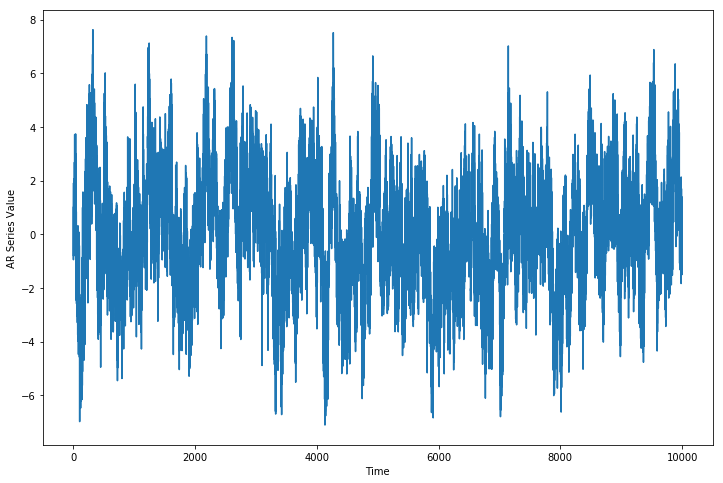

In [26]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as tsa
import matplotlib.pyplot as plt

# ensures experiment runs the same every time
np.random.seed(100)

# This function simluates an AR process, generating a new value based on historial values,
# autoregressive coefficients b1 ... bk, and some randomness.
def AR(b, X, mu, sigma):
    l = min(len(b)-1, len(X))
    b0 = b[0]
    
    return b0 + np.dot(b[1:l+1], X[-l:]) + np.random.normal(mu, sigma)

b = np.array([0, 0.8, 0.1, 0.05]) 
X = np.array([1])

mu = 0            
sigma = 1

for i in range(10000):
    X = np.append(X, AR(b, X, mu, sigma))         # shape (10001,) 인 auto-regressive series X 생성

plt.figure(figsize=(12,8))
plt.plot(X)
plt.xlabel('Time')
plt.ylabel('AR Series Value');

Auto-regressive model 은 spiky 한 특징을 가졌다. 그 이유는 past value 와 관계없는 stationary series 나 non-auto correlated series 는 time t 에 extreme value 가 있어도 time t+1 에 또 extreme value 가 있기 힘든데 반해, auto correlated series  는 t-1 에 extreme value 가 있으면 time t 에도 extreme value 가 있을 가능성이 높고 그 때문에 t-1 보다 더 extreme value 로 옮겨갈 가능성이 높다. 이러한 결과로 spike 모양의 behavior 를 보인다. 이 때문에 fat tail 이 생긴다.

이 process 가 central value 근처에서 어떻게 fluctuate 하는지 주목. 이 value 는 시계열의 평균이다. 시계열 전체에 걸쳐 constant 한 mean 을 가지고 있고 fluctuation 이 평균으로부터 일정 거리 내에서 왔다갔다 하는 것으로 보이므로, 이 series 는 stationary 하다는 가설을 세울 수 있다. 

We would want to rigorously test that in practice, which we will explore lightly in the examples at the end of this lecture. Also see the [stationarity lecture](https://www.quantopian.com/lectures/integration-cointegration-and-stationarity) from the Quantopian Lecture Series.

하지만, 이 경우는 우리가 stationary 하도록 model 을 만들었으므로 지금 stationary test 를 염려할 필요는 없다.

## Tail Risk (꼬리 위험)

Autoregressive processe 는 정규분포보다 더 extreme 한 값을 가지는 경향이 있다. 그 이유는 각 시점이 최근 값에 영향을 받기 때문이다. 시계열 값에 random jump 가 있으면 non-autoregressive series 보다 더 그 값에 머물 가능성이 높다. 이 것을  'fat-tailledness' (fat-tailed distribution) 라고 부르는데 pdf (확률 밀도 함수 (probability density function) : 확률 변수의 분포를 나타내는 함수) 의 끝 단이 정규분포 보다 더 두텁기 때문이다.

finance 에서 tail risk 가 많이 이야기 되는 이유는 tail event 가 실제로 일어나지만 드믈게 일어나므로 modeling 하기 어렵기 때문이다. ** 따라서 process 가 autoregressive 하다고 의심할 이유가 있으면, extreme fat tail event 의 위험을 예상하고 그에 따라 adjust 해야 한다.**

AR model 은 tail risk 의 여러 source 중 하나일 뿐이므로 시계열이 non-AR 이면 tail risk  가 없을 것이라고 가정해선 안된다.

We'll check for that behavior now.

**scipy.stats.norm.cdf(x, loc=0, scale=1) **: Cumulative distribution function of a normal continuous random variable. The location (loc) keyword specifies the mean. The scale (scale) keyword specifies the standard deviation.

* Fat Tail 여부에 대한 수학적 Sanity Check : Histogram 을 그려서 육안으로는 fat tail 여부 판단이 어려우므로 수학적으로 check 해야 함.

Fat Tail 의 발생 원인은 auto regressive 한 data 의 extreme case 발생이고 real world 에서 실제로 발생하므로 없다고 무시하면 안됨.

In [28]:
def compare_tails_to_normal(X):
    # Define matrix to store comparisons
    A = np.zeros((2,4))    
    
    for k in range(4):             
        #stores tail probabilities of the sample series vs a normal series
        A[0, k] = len(X[X > (k + 1)]) / float(len(X)) # Estimate tails of X        
        A[1, k] = 1 - stats.norm.cdf(k + 1) # Gaussian distribution 
        
    print('Frequency of std events in X \n1: %s\t2: %s\t3: %s\t4: %s' % tuple(A[0]))
    print('Frequency of std events in a normal process \n1: %s\t2: %s\t3: %s\t4: %s' % tuple(A[1]))
    
    return A

A = compare_tails_to_normal(X)

Frequency of std events in X 
1: 0.327567243276	2: 0.185481451855	3: 0.0909909009099	4: 0.035796420358
Frequency of std events in a normal process 
1: 0.158655253931	2: 0.0227501319482	3: 0.00134989803163	4: 3.16712418331e-05


X 는 mu = 0, sigma = 1 인 series data 이므로, 정규분포를 이루려면 sigma 4 이내의 data 가 Gaussian 은 99.99% 여야 하는데 X 의 경우 3.5 % 가 sigma 4 밖이고,  Gaussian 은 sigma 3 이내가  99.8% 이어야 하는데, X 는 9 % 의 fat tail 을 이루고 있음을 볼 수 있다.

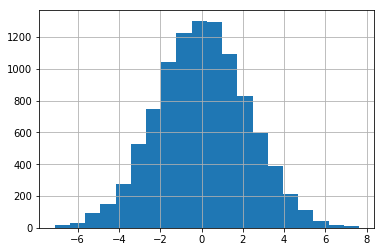

In [29]:
plt.hist(X, bins=20)
plt.grid(True);

위에서 보듯 histogram 으로는 eye-check 하여 fat tail 여부 판별하기 힘들다.

## Estimations of Variance Will be Wrong

AR process 가 fat tail 과 비정규 분포를 하고 있으므로, AR process 의 variance 계산은 틀릴 것이다. 이 것은 variance 가 통계에서 여러가지 quantity 계산 및 특히 신뢰구간과 p-value 계산에 사용되므로 위험하다. 신뢰구간의 폭이 종종 variance 계산에 근거하므로 autocorrelated 라고 생각되면 p-value 를 더 이상 신뢰할 수 없다.

 For more information on p-values please see the Hypothesis Testing notebook in the [Quantopian Lecture Series](https://www.quantopian.com/lectures).

p-value 는 confidence interval 과 관계있고, confidence interval 은 independent sampling 을 전제로 하는데, AR 이 있는 data 는 independent sampling 이 안되므로 p-value 의 전제가 성립되지 않는다.

과연 그런지 check 해 보자. 우선 임의의 input series 에 관하여 true value of mean 에 대해 순수하게 95% 신뢰구간을 계산하는 보조 함수를 작성한다.

1.96 std 에 mu (여기서는 0) 를 더하고 빼면 95% 구간의 lower, upper limit 을 얻는다. mu 를 0 로 하여 autocorrelated 한 series 를 X 를 만들었으므로 여기서 계산한 신뢰구간이 mean (0) 를 포함하는지 여부를 check 하면 위의 내용을 check 할 수 있다.

In [4]:
def compute_unadjusted_interval(X):
    T = len(X)
    # Compute mu and sigma MLE
    mu = np.mean(X)
    sigma = np.std(X)
    # Compute the bounds using standard error
    lower = mu - 1.96 * (sigma/np.sqrt(T))          # 95% confidence interval
    upper = mu + 1.96 * (sigma/np.sqrt(T))
    return lower, upper

# We'll make a function that returns true when the computed bounds contain 0
def check_unadjusted_coverage(X):
    l, u = compute_unadjusted_interval(X)
    # Check to make sure l <= 0 <= u
    if l <= 0 and u >= 0:
        return True
    else:
        return False
    
def simululate_AR_process(b, T):
    X = np.array([1])

    mu = 0
    sigma = 1

    for i in range(T):
        X = np.append(X, AR(b, X, mu, sigma))
        
    return X

이제 1000 번의 실험을 돌려서 AR series 를 계산하고 mean 과 순수 95% 신뢰구간을 계산한 후 신뢰구간이 0 (series 의 long-term mean) 을 포함하는지 check 하여  outcomes array 에 기록한다.

In [30]:
trials = 1000
outcomes = np.zeros((trials, 1))

for i in range(trials):
    #note these are the same values we used to generate the initial AR array
    Z = simululate_AR_process(np.array([0, 0.8, 0.1, 0.05]), 100)
    if check_unadjusted_coverage(Z):
        # The internal contains 0, the true value
        outcomes[i] = 1
    else:
        outcomes[i] = 0

Finally let's check, if our test is calibrated correctly, then we should have the confidence interval contain 0, 95% of the time.

In [6]:
np.sum(outcomes) / trials

0.193

confidence interval 95% 로 설정한 함수에서 19.3 % 만이 신뢰구간에 들어감. 따라서 AR data 는 완전히 fundamental condition 이 다르므로 modeling 을 다르게 해야함. Independent 한 data sampling 같은 normal statistic 은 적용되지 않음.

무언가 크게 잘못된 것 처럼 보인다. 이런 결과가 나온 이유는, AR series 가 크게 움직임에도 variance 의 계산을 stationary 라고 가정하여 모든 움직임을 고려하지 않았기 때문이다. 결과적으로, 신뢰구간은 원래 보다 작아졌고 충분히 정확한 값을 포함하지 않게 된 것이다.

This gives us a false sense of security. Stationarity tests should usually catch AR behavior and let us know that estimates of variance will be wrong. For more information please see the Integration, Cointegration, and Stationarity lecture of the [Quantopian Lecture Series](https://www.quantopian.com/lectures).

#### Correcting for Variance

In practice it can be very difficult to accurately estimate variance on an AR series, but one attempt to do this is the Newey-West estimation. You can find information on it [here](https://en.wikipedia.org/wiki/Newey%E2%80%93West_estimator).

그러나 Newey-West 는 없는 것보다 나은 nice-to-have tool 이다.

## Testing for AR Behavior

 AR$(p)$ model 의 $p$ (order) 를 결정하기 위해 시계열의 autocorrelation 을 관찰한다. 이 것은 과거 주가 series 의 correlation 이다. autocorrelation 의 $k$-th order 는 다음과 같다.

$$
\rho_k = \frac{COV(x_t, x_{t - k})}{\sigma_x^2} = \frac{E[(x_t - \mu)(x_{t - k} - \mu)}{\sigma_x^2}
$$

여기서 $k$ 는 lag 기간을 의미한다. 우리는 직접 autocorrelation 을 관찰할 수 없으므로 다음과 같이 계산한다. 

$$
\hat{\rho}_k = \frac{\sum_{t = k + 1}^T[(x_t - \bar{x})(x_{t - k} - \bar{x})]}{\sum_{t = 1}^T (x_t - \bar{x})^2}
$$

목적 달성을 위해 autocorrelation function (ACF) 와 partial autocorrelation function (PACF) 으로 불리는 두개의 tool 을 사용하여 우리 model 의 order 를 결정한다.ACF 와 달리 PACF 는 short lag 을 관리한다. 이 함수들은 많은 통계 package 에 포함되어 있고 sample autocorrelation 을 계산하여 우리가 적절한  $p$ 값을 결정할 수 있도록 해 준다.

위에서 구한 stationary series X 를 예로 하여 이 들 함수들을 어떻게 사용하는지 보여주겠다.

statsmodels.tsa.stattools.acf(x) : Autocorrelation function for 1d arrays.

statsmodels.tsa.stattools.pacf(x) : Partial autocorrelation estimated

In [31]:
from statsmodels.tsa.stattools import acf, pacf

In [32]:
X = simululate_AR_process(np.array([0, 0.8, 0.1, 0.05]), 1000)

In [33]:
# We'll choose 40 lags. This is a bit arbitrary, but you want to include all the lags you think might
# feasibly impact the current value.
nlags = 40
# Note, this will produce nlags + 1 values, as we include the autocorrelation of
# X[-1] with X[-1], which is trivially 1.
# The reason this is done is because that is the 0th spot in the array and corresponds
# to the 0th lag of X[(-1)-0].
X_acf = acf(X, nlags=nlags)
print('Autocorrelations:\n' + str(X_acf) + '\n')
X_pacf = pacf(X, nlags=nlags)
print('Partial Autocorrelations:\n' + str(X_pacf))

Autocorrelations:
[ 1.          0.57070553  0.58001725  0.88553976  0.55669882  0.57640436
  0.78307405  0.54759415  0.55254723  0.70158722  0.53082572  0.52673077
  0.62850967  0.50091633  0.48541475  0.56544198  0.46391848  0.45390828
  0.51491108  0.43375521  0.43938017  0.46783793  0.40843913  0.42270738
  0.42566802  0.38298857  0.38379558  0.40029717  0.36548704  0.36088258
  0.37743521  0.34745858  0.34065687  0.35239327  0.33194099  0.31758452
  0.33113111  0.31688646  0.2818213   0.31237461  0.31252031]

Partial Autocorrelations:
[ 1.          0.57127624  0.37827414  0.80672256  0.00162478  0.00490887
 -0.04497956  0.04013524 -0.05301909  0.00706455 -0.00528104  0.0051476
 -0.03421094 -0.03637203 -0.06841025  0.00396849 -0.02433695  0.03906542
  0.02344142  0.02958713  0.07306916 -0.01201434  0.00279546  0.01328444
 -0.00679875 -0.01547705 -0.09186641  0.05847768  0.03298422  0.04395628
 -0.01605778  0.00286143 -0.00734411 -0.01496441  0.01152254 -0.01185183
  0.01895763  0.01

Let's plot out the values now.

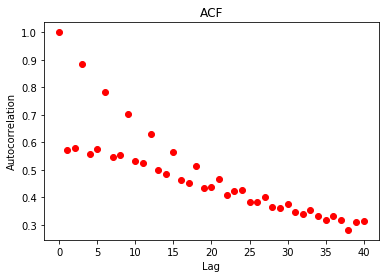

In [10]:
plt.plot(X_acf, 'ro')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title("ACF");

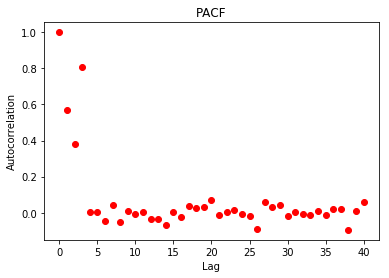

In [11]:
plt.plot(X_pacf, 'ro')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title("PACF");

#### Statistical Testing

단순히 graph 만 보는 것은 충분하지 않으므로 어느정도의 통계적 견고함을 이용한다.  `acf` 와 `pacf`함수는 모든 autocorrelation 에 대해 confidence interval 을 반환한다. 이 신뢰구간이 zero 에 overlap 되는지 check 할 수 있다. 그런 경우 우리는 zero 가 true parameter value 에 대해 confidence interval set 내에 있다고 말 할 수 있고 lag 가 어떠한 의미있는 autocorrelation 을 가진 것으로 취급하지 않는다.

NOTE: This only works if the assumptions underlying the confidence interval computations are satisfied. Please check these assumptions before you assume the test is meaningful. The assumptions will differ in every case, so please read the statistical documentation of your own test and go from there.

In [34]:
# We have to set a confidence level for our intervals, we choose the standard of 95%,
# corresponding with an alpha of 0.05.
X_acf, X_acf_confs = acf(X, nlags=nlags, alpha=0.05)
X_pacf, X_pacf_confs = pacf(X, nlags=nlags, alpha=0.05)

After getting the confidence interval data, we'll write a function to plot it.

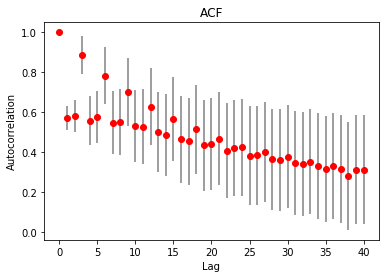

In [35]:
def plot_acf(X_acf, X_acf_confs, title='ACF'):
    # The confidence intervals are returned by the functions as (lower, upper)
    # The plotting function needs them in the form (x-lower, upper-x)
    errorbars = np.ndarray((2, len(X_acf)))
    errorbars[0, :] = X_acf - X_acf_confs[:,0]
    errorbars[1, :] = X_acf_confs[:,1] - X_acf

    plt.plot(X_acf, 'ro')
    plt.errorbar(range(len(X_acf)), X_acf, yerr=errorbars, fmt='none', ecolor='gray', capthick=2)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title);
plot_acf(X_acf, X_acf_confs)

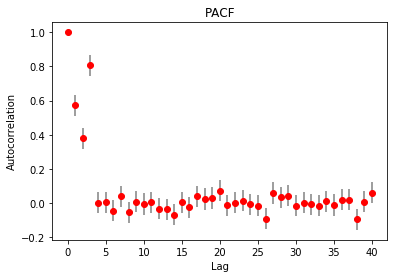

In [14]:
plot_acf(X_pacf, X_pacf_confs, title='PACF')

처음 3 개만 correlation 이 있어 보이고 그 이후는 상관 없어 보임.

Notice how for the PACF, only the first three lags are the only ones that appear to be significantly different from $0$, which makes sense because we directly constructed an AR model of order $3$. However, these results may vary for each random series generated in this notebook.


In a real-world time series, we use these plots to determine the order of our model. We would then attempt to fit a model using a maximum likelihood function.

## Fitting a Model

We'll use one of the functions already implemented in Python to fit an AR model. We'll try this on our simulated data first.

In [15]:
# Construct an unfitted model
model = tsa.api.AR(X)
# Fit it
model = model.fit()

The `model` object has a lot of useful information on it, use the `?` notation to find out more. We'll be focusing on a few attributes, starting with `model.params` the estimated parameters in the model, one for each lag, and `model.bse`, the estimated standard error for each of the parameters.

In [16]:
print('Parameters')
print(model.params)
print('Standard Error')
print(model.bse)

Parameters
[ 0.01001762  0.04631952  0.06669125  0.84444655 -0.02662476  0.07031018
 -0.03883539  0.05362627 -0.06257934  0.03183551  0.02255835  0.06366225
 -0.02663838 -0.00824025 -0.09032174 -0.02259851 -0.05894006 -0.03575162
  0.01899755  0.0265497   0.08158745 -0.00494997]
Standard Error
[ 0.03210283  0.03228516  0.03221285  0.03226938  0.04224386  0.04226218
  0.04228528  0.04223737  0.04222499  0.04230633  0.04232241  0.04227582
  0.04230175  0.04232492  0.04221253  0.04221065  0.04218858  0.04214434
  0.04212185  0.03217742  0.03220652  0.03227438]


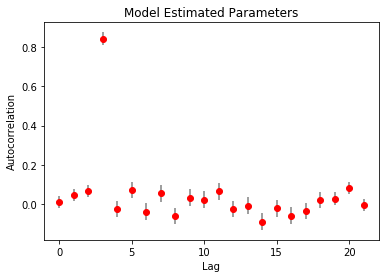

In [17]:
# To plot this we'll need to format a confidence interval 2D array like the previous functions returned
# Here is some quick code to do that
model_confs = np.asarray((model.params - model.bse, model.params + model.bse)).T

plot_acf(model.params, model_confs, title='Model Estimated Parameters')

### Choosing the Number of Lags

#### Estimations Will Yield Too Many Lags

We can see our model estimated quite a few parameters. In this case we know there are too many because we simulated the data as an AR(3) process. The reason that AR models will estimate many more lags than is actually the case is due to indirect dependency. If $X_t$ depends on $X_{t-1}$, then indirectly and to a lesser extent it will depend on $X_{t-2}$. In the presence of more than one lag in the data generating process, we will get potentially complex harmonic structures in the lags. These indirect dependencies will be picked up by a simple estimation.

#### You Want the Fewest Parameters That Yield a Decent Model

In general it's rarely the case that you can get anything useful out of a model with many parameters, see the Overfitting lecture for why in the Quantopian Lecture Series. In this case we want to select a number of lags that we believe explains what is happening, but without overfitting and choosing a model with way too many lags. 

Observing the ACF and PACF indicates that only the first 3 lags may be useful. However, we will expand the number of lags to 10 to double-check our initial data. We will use information criterion, specifically Akaike Information Criterion (AIC) and Bayes Information Criterion (BIC) to decide the correct number of parameters. For more information on choosing models using information criterion, please see the corresponding lecture in the Quantopian Lecture Series.

Interpreting the AIC and BIC is done as follows. Compute the AIC and BIC for all models we wish to consider, and note the smallest AIC and BIC recorded $AIC_{min}$ and $BIC_{min}$. These are the models which minimize information loss under each metric. For each type of IC We then can compute the *relative likelihood* of each model $i$ by taking 

$$l = e^{(IC_{min} - IC_{i})/2}$$

We can interpret $l$ as model $i$ is $l$ times as likely to minimize information loss, compared to the minimum AIC model. It might take a few reads to understand this, so let's just see it in action.

In [18]:
N = 10
AIC = np.zeros((N, 1))

for i in range(N):
    model = tsa.api.AR(X)
    model = model.fit(maxlag=(i+1))
    AIC[i] = model.aic
    
AIC_min = np.min(AIC)
model_min = np.argmin(AIC)

print('Relative Likelihoods')
print(np.exp((AIC_min-AIC) / 2))
print('Number of parameters in minimum AIC model %s' % (model_min+1))

Relative Likelihoods
[[ 0.54739169]
 [ 0.59052713]
 [ 0.99861675]
 [ 0.997749  ]
 [ 0.99628437]
 [ 0.99619915]
 [ 0.9960884 ]
 [ 1.        ]
 [ 0.99850924]
 [ 0.99809322]]
Number of parameters in minimum AIC model 8


In [19]:
N = 10
BIC = np.zeros((N, 1))

for i in range(N):
    model = tsa.api.AR(X)
    model = model.fit(maxlag=(i+1))
    BIC[i] = model.bic
    
BIC_min = np.min(BIC)
model_min = np.argmin(BIC)

print('Relative Likelihoods')
print(np.exp((BIC_min-BIC) / 2))
print('Number of parameters in minimum BIC model %s' % (model_min+1))

Relative Likelihoods
[[ 0.5508575 ]
 [ 0.59280494]
 [ 1.        ]
 [ 0.99666667]
 [ 0.99274501]
 [ 0.99020386]
 [ 0.98763995]
 [ 0.98905709]
 [ 0.9851272 ]
 [ 0.98226451]]
Number of parameters in minimum BIC model 3


Our conclusion is that the AIC estimates the 4 parameter model as most likely, whereas the BIC estimates 3. Because we are always looking for reasons to knock off a parameter, we choose the 3. In this case it happened to be the exact right answer, but this will not always be the case, especially in noisy real data. Don't assume that using this method will always get you the right answer.

### Evaluating Residuals

One final step we might do before performing an out of sample test for this model would be to evaluate its residual behavior. The AIC and BIC already do this to an extent, effectively measuring how much information is left on the table (in the residuals) after the model has made its predictions. For more information on residuals analysis see the Violations of Regression Models lecture. Here we'll just check for normality of the residuals.

In [20]:
model = tsa.api.AR(X)
model = model.fit(maxlag=3)

from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(model.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

The residuals seem normally distributed.


The residuals seem normally distributed. There are more model validation steps that could be done, but these are the core ones for an AR model. The next steps would be testing the model out of sample, and then using it to make predictions on your data.

## References
* "Quantitative Investment Analysis", by DeFusco, McLeavey, Pinto, and Runkle
* "Analysis of Financial Time Series", by Ruey Tsay